# 3 Model Exploration

## 3.1 Imports and dataset loading

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, make_scorer, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
output_dir = '../output/'
df = pd.read_csv(output_dir + 'df_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 19701 rows, 41 columns


In [3]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19701 entries, 0 to 19700
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Any                        19701 non-null  int64  
 1   zona                       19701 non-null  int64  
 2   nomCom                     19701 non-null  int64  
 3   nomDem                     19701 non-null  int64  
 4   F_MORTS                    19701 non-null  int64  
 5   F_FERITS_GREUS             19701 non-null  int64  
 6   F_FERITS_LLEUS             19701 non-null  int64  
 7   F_VICTIMES                 19701 non-null  int64  
 8   F_UNITATS_IMPLICADES       19701 non-null  int64  
 9   F_VIANANTS_IMPLICADES      19701 non-null  int64  
 10  F_BICICLETES_IMPLICADES    19701 non-null  int64  
 11  F_CICLOMOTORS_IMPLICADES   19701 non-null  int64  
 12  F_MOTOCICLETES_IMPLICADES  19701 non-null  int64  
 13  F_VEH_LLEUGERS_IMPLICADES  19701

In [4]:
print("\nTarget variable distribution:")
print(df['Mortalitat'].value_counts().sort_index())
print("\nTarget proportions:")
print(df['Mortalitat'].value_counts(normalize=True).sort_index())



Target variable distribution:
Mortalitat
0    16789
1     2912
Name: count, dtype: int64

Target proportions:
Mortalitat
0    0.85219
1    0.14781
Name: proportion, dtype: float64


## 3.2 Data preparation and splits

### Separate features and target

In [5]:
# Remove features that directly encode the target, as seen in EDA
# F_MORTS (deaths), F_FERITS_GREUS (serious injuries), F_FERITS_LLEUS (light injuries), F_VICTIMES (victims)
# These should not be available at prediction time
leakage_features = ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']

X = df.drop(columns=['Mortalitat'] + leakage_features)
y = df['Mortalitat']

print(f"Removed leakage features: {leakage_features}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures ({X.shape[1]} columns):")
print(X.columns.tolist())

Removed leakage features: ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']
Features shape: (19701, 36)
Target shape: (19701,)

Features (36 columns):
['Any', 'zona', 'nomCom', 'nomDem', 'F_UNITATS_IMPLICADES', 'F_VIANANTS_IMPLICADES', 'F_BICICLETES_IMPLICADES', 'F_CICLOMOTORS_IMPLICADES', 'F_MOTOCICLETES_IMPLICADES', 'F_VEH_LLEUGERS_IMPLICADES', 'F_VEH_PESANTS_IMPLICADES', 'C_VELOCITAT_VIA', 'D_BOIRA', 'D_CARACT_ENTORN', 'D_CARRIL_ESPECIAL', 'D_CIRCULACIO_MESURES_ESP', 'D_CLIMATOLOGIA', 'D_FUNC_ESP_VIA', 'D_INTER_SECCIO', 'D_LIMIT_VELOCITAT', 'D_LLUMINOSITAT', 'D_REGULACIO_PRIORITAT', 'D_SENTITS_VIA', 'D_SUBTIPUS_ACCIDENT', 'D_SUBTIPUS_TRAM', 'D_SUBZONA', 'D_SUPERFICIE', 'D_TIPUS_VIA', 'D_TITULARITAT_VIA', 'D_TRACAT_ALTIMETRIC', 'D_VENT', 'hor', 'grupHor', 'tipAcc', 'tipDia', 'Mes']


### Stratified Train/Val/Test split

In [6]:
# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Dataset splits:")
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nClass distribution across splits:")
print("\nTrain:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nVal:")
print(y_val.value_counts(normalize=True).sort_index())
print("\nTest:")
print(y_test.value_counts(normalize=True).sort_index())


Dataset splits:
Train set: 13790 samples (70.0%)
Val set:   2955 samples (15.0%)
Test set:  2956 samples (15.0%)

Class distribution across splits:

Train:
Mortalitat
0    0.852212
1    0.147788
Name: proportion, dtype: float64

Val:
Mortalitat
0    0.852115
1    0.147885
Name: proportion, dtype: float64

Test:
Mortalitat
0    0.852165
1    0.147835
Name: proportion, dtype: float64


### Feature scaling

In [7]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to dfs
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using RobustScaler")


Features scaled using RobustScaler


### Class weights (for imbalanced data)

In [8]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights (for handling imbalance):")
print(f"Class 0 (No mortality): {class_weight_dict[0]:.4f}")
print(f"Class 1 (Mortality): {class_weight_dict[1]:.4f}")

Class Weights (for handling imbalance):
Class 0 (No mortality): 0.5867
Class 1 (Mortality): 3.3832


## 3.3 Model exploration

We want to explore different families of models and compare their performance using one same evaluation framework, so that we can select the best model for further hyperparameter tuning and analysis based on the observed trade-offs.

We will be storing an object per each model containing the model itself and its evaluation results, so that we can summarize and compare them later on.

In [9]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """
    Comprehensive model evaluation on train, val, and test sets using optimized threshold.
    Also measures inference time on validation set
    """
    results = {}
    best_threshold = 0.5  # Default for models without predict_proba
    
    # 1. Optimize Threshold on Validation Set (only if model supports probabilities)
    if hasattr(model, 'predict_proba'):
        # Get probabilities for the positive class
        y_val_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
        
        # Calculate F1 scores for each threshold
        # Note: precisions and recalls have 1 extra element (for threshold=1)
        with np.errstate(divide='ignore', invalid='ignore'):
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        f1_scores = np.nan_to_num(f1_scores)  # Handle division by zero
        
        # Find the index of the best F1 score
        best_idx = np.argmax(f1_scores)
        
        # Select the corresponding threshold
        if best_idx < len(thresholds):
            best_threshold = thresholds[best_idx]
        else:
            best_threshold = 0.5 # Fallback if something goes wrong
            
        print(f"{model_name} - Optimized Threshold: {best_threshold:.4f}")

    # 2. Evaluate on all sets using the best threshold
    for set_name, X_set, y_set in [
        ('Train', X_train, y_train),
        ('Val', X_val, y_val),
        ('Test', X_test, y_test)
    ]:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_set)[:, 1]
            # Apply the optimized threshold
            y_pred = (y_proba >= best_threshold).astype(int)
            metrics_auc = roc_auc_score(y_set, y_proba)
        else:
            # Fallback for models like LinearSVC (without probability=True)
            y_pred = model.predict(X_set)
            metrics_auc = None
        
        metrics = {
            'Accuracy': accuracy_score(y_set, y_pred),
            'Precision': precision_score(y_set, y_pred, zero_division=0),
            'Recall': recall_score(y_set, y_pred, zero_division=0),
            'F1': f1_score(y_set, y_pred, zero_division=0),
        }
        
        if metrics_auc is not None:
            metrics['ROC-AUC'] = metrics_auc
        
        results[set_name] = metrics
    
    # 3. Inference Time (standard predict)
    start_time = time.time()
    _ = model.predict(X_val)
    inference_time = (time.time() - start_time) / len(X_val) * 1000  # ms per sample
    results['Inference Time (ms/sample)'] = inference_time
    
    # Store the threshold used
    results['Best Threshold'] = best_threshold
    
    return results

def plot_confusion_matrix(model, X_test, y_test, model_name, threshold=0.5):
    # Generate predictions based on the specific threshold
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['No Mortality', 'Mortality'],
                yticklabels=['No Mortality', 'Mortality'])
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{model_name} - Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Mortality', 'Mortality']))

### Logistic regression

Linear model that estimates the probability of an event occurring by fitting a logistic function to the input features. It assumes a linear relationship between the input variables and the odds of the outcome.

Explainability is high (glassbox). We can directly interpret the model's coefficients. A positive coefficient increases the probability of the target class, while a negative one decreases it.


Logistic Regression - Optimized Threshold: 0.5533


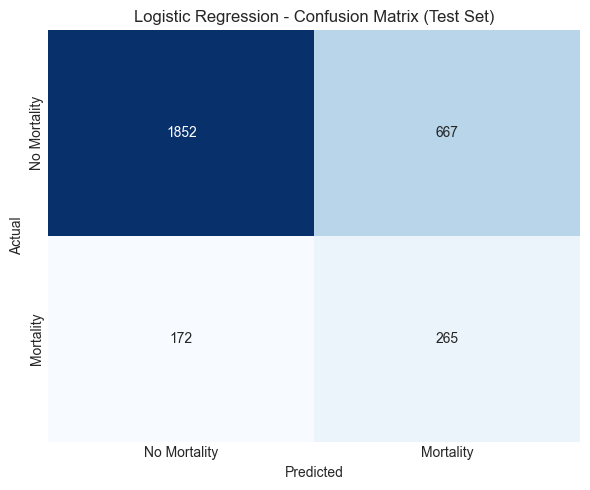


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.92      0.74      0.82      2519
   Mortality       0.28      0.61      0.39       437

    accuracy                           0.72      2956
   macro avg       0.60      0.67      0.60      2956
weighted avg       0.82      0.72      0.75      2956



In [10]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lr_train_start = time.time()
lr.fit(X_train_scaled, y_train)
lr_train_time = time.time() - lr_train_start

lr_results = evaluate_model(lr, X_train_scaled, X_val_scaled, X_test_scaled, 
                            y_train, y_val, y_test, 'Logistic Regression')

lr_info = {
    'model': lr,
    'training_time': lr_train_time,
    'inference_time': lr_results['Inference Time (ms/sample)'],
    'parameters': len(lr.coef_[0]),
    'train_results': lr_results['Train'],
    'test_results': lr_results['Test'],
    'best_threshold': lr_results['Best Threshold']
}

plot_confusion_matrix(lr, X_test_scaled, y_test, 'Logistic Regression', threshold=lr_info['best_threshold'])

### Decision tree

A non-parametric model that splits data into subsets based on feature values, creating a tree-like structure of decision rules to reach a prediction.

Explainability is high (glassbox). We can visualize the tree structure and follow the path from the root to the leaf node to understand the logic behind a specific prediction.



Decision Tree - Optimized Threshold: 0.5958


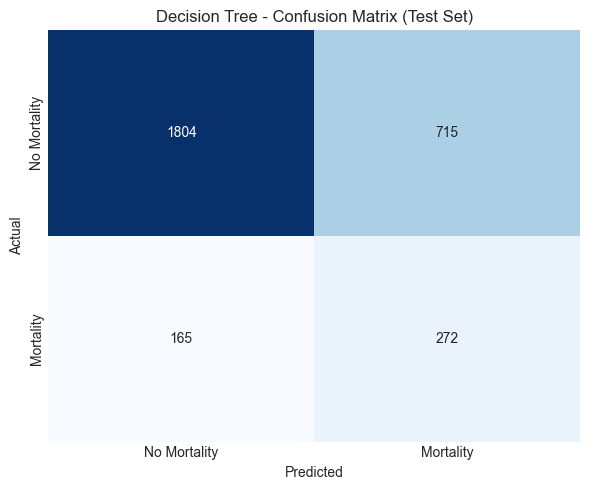


Decision Tree - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.92      0.72      0.80      2519
   Mortality       0.28      0.62      0.38       437

    accuracy                           0.70      2956
   macro avg       0.60      0.67      0.59      2956
weighted avg       0.82      0.70      0.74      2956



In [79]:
dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42,
    max_depth=8,
    ccp_alpha=0.001,
)

dt_train_start = time.time()
dt.fit(X_train_scaled, y_train)
dt_train_time = time.time() - dt_train_start

dt_results = evaluate_model(dt, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Decision Tree')

dt_info = {
    'model': dt,
    'training_time': dt_train_time,
    'inference_time': dt_results['Inference Time (ms/sample)'],
    'parameters': dt.tree_.node_count,
    'train_results': dt_results['Train'],
    'test_results': dt_results['Test'],
    'best_threshold': dt_results['Best Threshold']
}

plot_confusion_matrix(dt, X_test_scaled, y_test, 'Decision Tree', threshold=dt_info['best_threshold'])

### Random forest

An ensemble method that constructs a multitude of decision trees during training. It outputs the class that is the mode of the classes of the individual trees, reducing overfitting compared to single decision trees.

Explainability is medium (black-box). While more complex than a single tree, it allows for global interpretation via Feature Importance scores. For local interpretability, use SHAP values to see the contribution of each feature.



Random Forest - Optimized Threshold: 0.5453


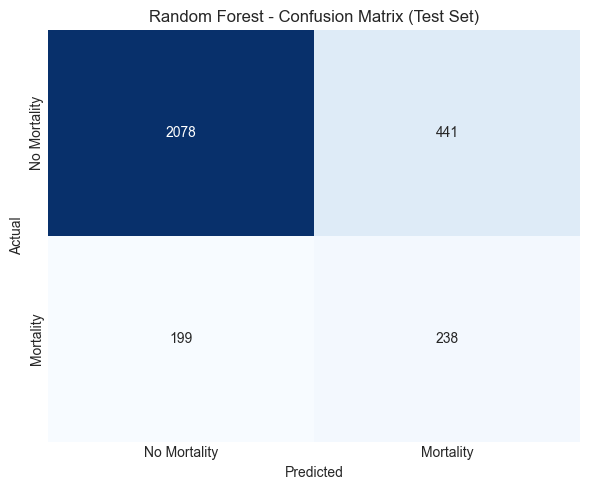


Random Forest - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.82      0.87      2519
   Mortality       0.35      0.54      0.43       437

    accuracy                           0.78      2956
   macro avg       0.63      0.68      0.65      2956
weighted avg       0.83      0.78      0.80      2956



In [70]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=10,
    min_samples_leaf=10,
)

rf_train_start = time.time()
rf.fit(X_train_scaled, y_train)
rf_train_time = time.time() - rf_train_start

rf_results = evaluate_model(rf, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Random Forest')

rf_info = {
    'model': rf,
    'training_time': rf_train_time,
    'inference_time': rf_results['Inference Time (ms/sample)'],
    'parameters': sum(t.tree_.node_count for t in rf.estimators_),
    'train_results': rf_results['Train'],
    'test_results': rf_results['Test'],
    'best_threshold': rf_results['Best Threshold']
}

plot_confusion_matrix(rf, X_test_scaled, y_test, 'Random Forest', threshold=rf_info['best_threshold'])

### Gradient boosting

A standard boosting model that builds trees sequentially, where each new tree corrects the errors of the previous ones.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.


Gradient Boosting - Optimized Threshold: 0.1990


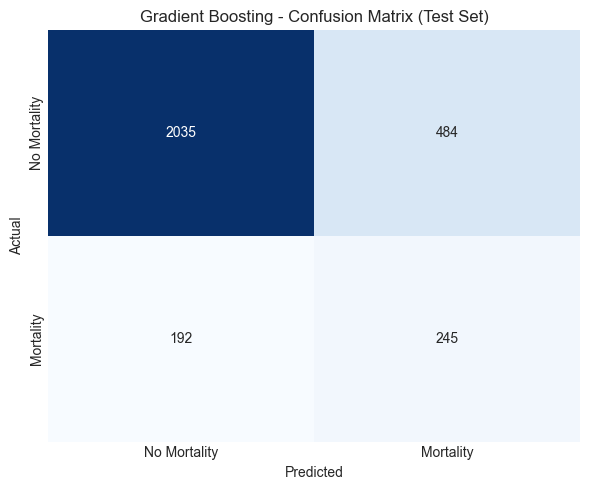


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.81      0.86      2519
   Mortality       0.34      0.56      0.42       437

    accuracy                           0.77      2956
   macro avg       0.62      0.68      0.64      2956
weighted avg       0.83      0.77      0.79      2956



In [ ]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
)

gb_train_start = time.time()
gb.fit(X_train_scaled, y_train)
gb_train_time = time.time() - gb_train_start

gb_results = evaluate_model(gb, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Gradient Boosting')

gb_info = {
    'model': gb,
    'training_time': gb_train_time,
    'inference_time': gb_results['Inference Time (ms/sample)'],
    'parameters': sum(t.tree_.node_count for t in gb.estimators_.ravel()),
    'train_results': gb_results['Train'],
    'test_results': gb_results['Test'],
    'best_threshold': gb_results['Best Threshold']
}

plot_confusion_matrix(gb, X_test_scaled, y_test, 'Gradient Boosting', threshold=gb_info['best_threshold'])

### XGBoost classifier

An optimized version of the gradient boosting algorithm.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.





XGBoost - Optimized Threshold: 0.5788


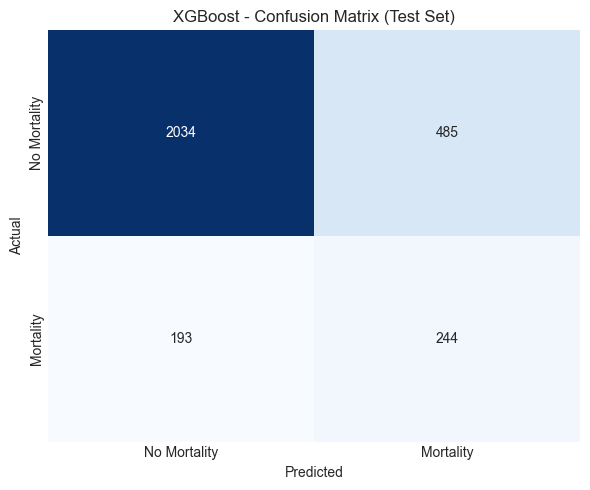


XGBoost - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.81      0.86      2519
   Mortality       0.33      0.56      0.42       437

    accuracy                           0.77      2956
   macro avg       0.62      0.68      0.64      2956
weighted avg       0.83      0.77      0.79      2956



In [50]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    colsample_bytree=0.6,
)

xgb_train_start = time.time()
xgb.fit(X_train_scaled, y_train)
xgb_train_time = time.time() - xgb_train_start

xgb_results = evaluate_model(xgb, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'XGBoost')

xgb_info = {
    'model': xgb,
    'training_time': xgb_train_time,
    'inference_time': xgb_results['Inference Time (ms/sample)'],
    'parameters': xgb.n_estimators * 5,  # Approximate
    'train_results': xgb_results['Train'],
    'test_results': xgb_results['Test'],
    'best_threshold': xgb_results['Best Threshold']
}

plot_confusion_matrix(xgb, X_test_scaled, y_test, 'XGBoost', threshold=xgb_info['best_threshold'])

### Support Vector Machine

A powerful classifier that finds the hyperplane that best divides a dataset into two classes with the maximum margin. It can handle non-linear boundaries using kernel functions.

Explainability is low (black-box). When using non-linear kernels, the relationship between features and the output is not direct. SHAP (KernelExplainer) is needed for interpretability.

SVM - Optimized Threshold: 0.2148


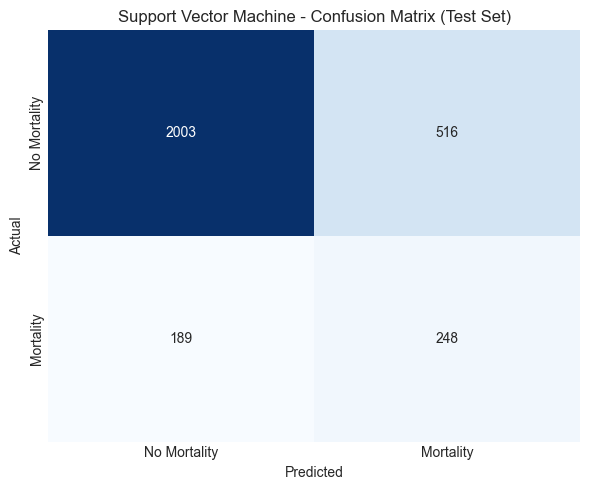


Support Vector Machine - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.80      0.85      2519
   Mortality       0.32      0.57      0.41       437

    accuracy                           0.76      2956
   macro avg       0.62      0.68      0.63      2956
weighted avg       0.83      0.76      0.79      2956



In [15]:
svm = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42,
    probability=True
)

svm_train_start = time.time()
svm.fit(X_train_scaled, y_train)
svm_train_time = time.time() - svm_train_start

svm_results = evaluate_model(svm, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'SVM')

svm_info = {
    'model': svm,
    'training_time': svm_train_time,
    'inference_time': svm_results['Inference Time (ms/sample)'],
    'parameters': len(svm.support_vectors_),
    'train_results': svm_results['Train'],
    'test_results': svm_results['Test'],
    'best_threshold': svm_results['Best Threshold']
}

plot_confusion_matrix(svm, X_test_scaled, y_test, 'Support Vector Machine', threshold=svm_info['best_threshold'])

### LightGBM (Light Gradient Boosting Machine)

A gradient boosting framework that uses tree-based learning algorithms. It is designed for distributed and efficient training, often faster than XGBoost and capable of handling large-scale data.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.

LightGBM - Optimized Threshold: 0.5529


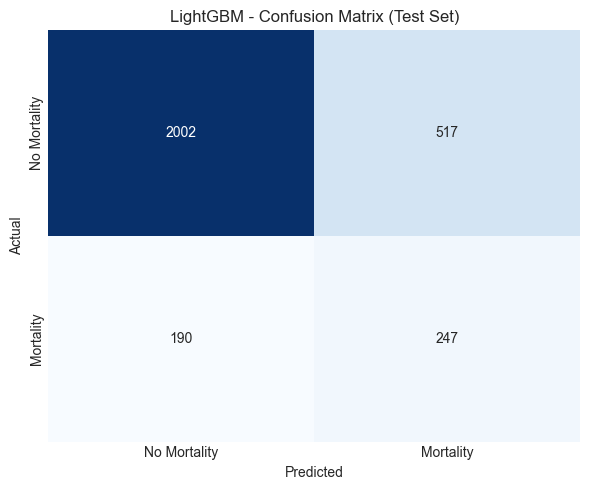


LightGBM - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.79      0.85      2519
   Mortality       0.32      0.57      0.41       437

    accuracy                           0.76      2956
   macro avg       0.62      0.68      0.63      2956
weighted avg       0.83      0.76      0.79      2956



In [66]:
lgb = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_train_start = time.time()
lgb.fit(X_train_scaled, y_train)
lgb_train_time = time.time() - lgb_train_start

lgb_results = evaluate_model(lgb, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'LightGBM')

lgb_info = {
    'model': lgb,
    'training_time': lgb_train_time,
    'inference_time': lgb_results['Inference Time (ms/sample)'],
    'parameters': lgb.n_estimators * 5,  # Approximate
    'train_results': lgb_results['Train'],
    'test_results': lgb_results['Test'],
    'best_threshold': lgb_results['Best Threshold']
}

plot_confusion_matrix(lgb, X_test_scaled, y_test, 'LightGBM', threshold=lgb_info['best_threshold'])


### CatBoost classifier

A gradient boosting method that handles categorical features efficiently. It uses symmetric trees to reduce overfitting and speed up prediction.

Explainability is medium (black-box): being a boosting model, SHAP is needed for interpretability.

CatBoost - Optimized Threshold: 0.5986


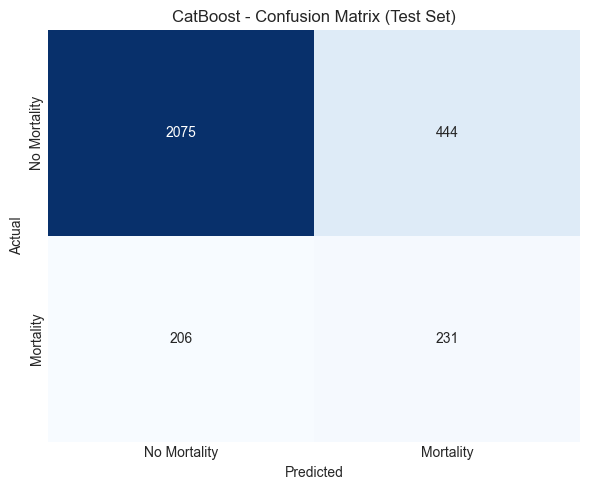


CatBoost - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.82      0.86      2519
   Mortality       0.34      0.53      0.42       437

    accuracy                           0.78      2956
   macro avg       0.63      0.68      0.64      2956
weighted avg       0.83      0.78      0.80      2956



In [17]:
cat = CatBoostClassifier(
    iterations=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    auto_class_weights='Balanced',
    verbose=0,
    train_dir=None
)

cat_train_start = time.time()
cat.fit(X_train_scaled, y_train)
cat_train_time = time.time() - cat_train_start

cat_results = evaluate_model(cat, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'CatBoost')

cat_info = {
    'model': cat,
    'training_time': cat_train_time,
    'inference_time': cat_results['Inference Time (ms/sample)'],
    'parameters': cat.tree_count_ * 5,  # Approximate
    'train_results': cat_results['Train'],
    'test_results': cat_results['Test'],
    'best_threshold': cat_results['Best Threshold']
}

plot_confusion_matrix(cat, X_test_scaled, y_test, 'CatBoost', threshold=cat_info['best_threshold'])


### Multilayer perceptron

A class of feedforward artificial neural networks. It consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. It can model complex non-linear relationships.

Explainability is low (black-box). The "deep" internal structure of weights makes it difficult to interpret directly. Explainability relies on methods like SHAP (DeepExplainer).

MLP - Optimized Threshold: 0.1615


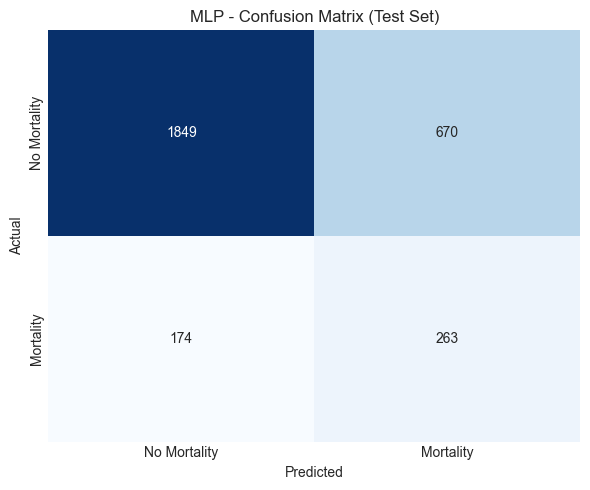


MLP - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.73      0.81      2519
   Mortality       0.28      0.60      0.38       437

    accuracy                           0.71      2956
   macro avg       0.60      0.67      0.60      2956
weighted avg       0.82      0.71      0.75      2956



In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

mlp_train_start = time.time()
mlp.fit(X_train_scaled, y_train)
mlp_train_time = time.time() - mlp_train_start

mlp_results = evaluate_model(mlp, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'MLP')

mlp_info = {
    'model': mlp,
    'training_time': mlp_train_time,
    'inference_time': mlp_results['Inference Time (ms/sample)'],
    'parameters': sum(w.size for w in mlp.coefs_) + sum(b.size for b in mlp.intercepts_),
    'train_results': mlp_results['Train'],
    'test_results': mlp_results['Test'],
    'best_threshold': mlp_results['Best Threshold']
}

plot_confusion_matrix(mlp, X_test_scaled, y_test, 'MLP', threshold=mlp_info['best_threshold'])


### k-Nearest Neighbors

A simple, instance-based learning algorithm that classifies a new data point based on the majority class of its 'k' nearest neighbors in the feature space.

Explainability is medium. It is interpreted by example: "We predicted Class A because the 5 most similar historical cases were also Class A." However, it doesn't provide a formulaic explanation of which features drove the similarity.

k-NN - Optimized Threshold: 0.2000


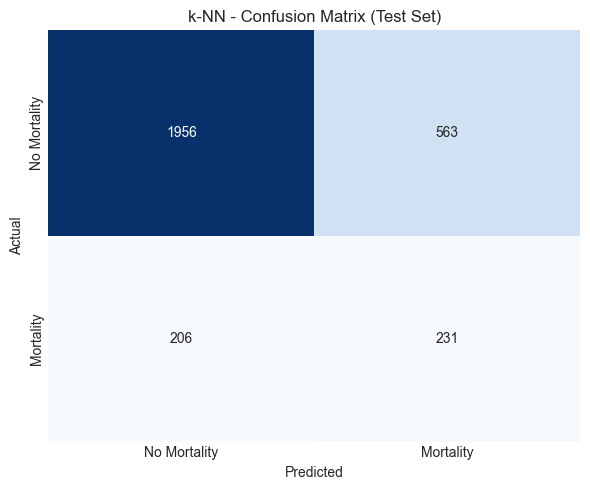


k-NN - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.90      0.78      0.84      2519
   Mortality       0.29      0.53      0.38       437

    accuracy                           0.74      2956
   macro avg       0.60      0.65      0.61      2956
weighted avg       0.81      0.74      0.77      2956



In [39]:
knn = KNeighborsClassifier(
    n_neighbors=50,
    n_jobs=-1,
    weights='uniform'
)

knn_train_start = time.time()
knn.fit(X_train_scaled, y_train)
knn_train_time = time.time() - knn_train_start

knn_results = evaluate_model(knn, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'k-NN')

knn_info = {
    'model': knn,
    'training_time': knn_train_time,
    'inference_time': knn_results['Inference Time (ms/sample)'],
    'parameters': len(X_train_scaled),  # All training samples are parameters
    'train_results': knn_results['Train'],
    'test_results': knn_results['Test'],
    'best_threshold': knn_results['Best Threshold']
}

plot_confusion_matrix(knn, X_test_scaled, y_test, 'k-NN', threshold=knn_info['best_threshold'])


### Gaussian Naive Bayes

A probabilistic classifier based on applying Bayes' theorem with strong independence assumptions between the features. It assumes features follow a normal distribution.

Explainability is high. It provides probabilities for each class based on individual features. We can easily see which feature pushed the probability towards a specific class, making it very transparent.

Gaussian Naive Bayes - Optimized Threshold: 0.1648


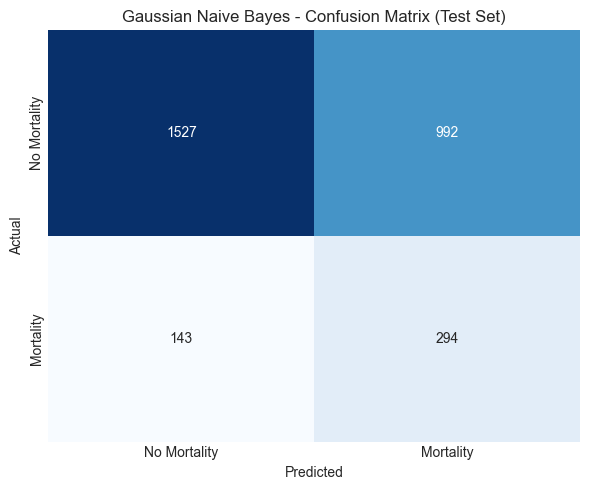


Gaussian Naive Bayes - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.61      0.73      2519
   Mortality       0.23      0.67      0.34       437

    accuracy                           0.62      2956
   macro avg       0.57      0.64      0.54      2956
weighted avg       0.81      0.62      0.67      2956



In [20]:
nb = GaussianNB()

nb_train_start = time.time()
nb.fit(X_train_scaled, y_train)
nb_train_time = time.time() - nb_train_start

nb_results = evaluate_model(nb, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Gaussian Naive Bayes')

nb_info = {
    'model': nb,
    'training_time': nb_train_time,
    'inference_time': nb_results['Inference Time (ms/sample)'],
    'parameters': len(nb.var_) * 2,  # Mean and variance for each feature
    'train_results': nb_results['Train'],
    'test_results': nb_results['Test'],
    'best_threshold': nb_results['Best Threshold']
}

plot_confusion_matrix(nb, X_test_scaled, y_test, 'Gaussian Naive Bayes', threshold=nb_info['best_threshold'])


### Explainable Boosting Machines (EBM)

A model that combines the power of gradient boosting with the interpretability of generalized additive models (GAMs). It learns a graph for each feature's contribution to the prediction.

Explainability is high (glassbox). Designed specifically for interpretability. It provides exact graphs showing how each feature affects the prediction across its entire range, without needing approximation tools like SHAP.

EBM - Optimized Threshold: 0.1893


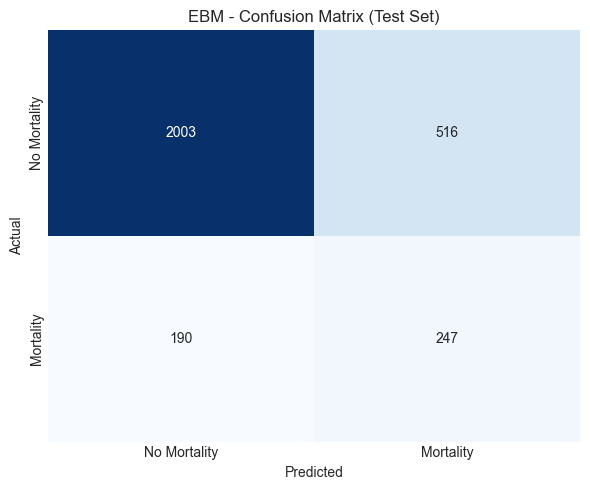


EBM - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.80      0.85      2519
   Mortality       0.32      0.57      0.41       437

    accuracy                           0.76      2956
   macro avg       0.62      0.68      0.63      2956
weighted avg       0.83      0.76      0.79      2956



In [21]:
ebm = ExplainableBoostingClassifier(
    max_leaves=16,
    learning_rate=0.01,
    random_state=42,
    n_jobs=-1
)

ebm_train_start = time.time()
ebm.fit(X_train_scaled, y_train)
ebm_train_time = time.time() - ebm_train_start

ebm_results = evaluate_model(ebm, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'EBM')

ebm_info = {
    'model': ebm,
    'training_time': ebm_train_time,
    'inference_time': ebm_results['Inference Time (ms/sample)'],
    'parameters': X_train_scaled.shape[1],  # One function per feature
    'train_results': ebm_results['Train'],
    'test_results': ebm_results['Test'],
    'best_threshold': ebm_results['Best Threshold']
}

plot_confusion_matrix(ebm, X_test_scaled, y_test, 'EBM', threshold=ebm_info['best_threshold'])


### Linear SVM (fast alternative to SVM)

A version of SVM specialized for linear decision boundaries (without kernels). It is faster to train and specifically effective for high-dimensional sparse data.

Explainability is high. Since it uses a linear boundary, we can inspect the coefficients (weights) assigned to each feature to understand their direction and magnitude of influence, similar to Logistic Regression.

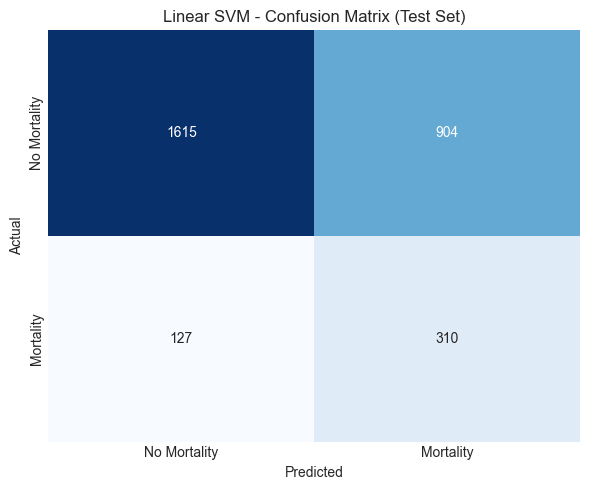


Linear SVM - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.93      0.64      0.76      2519
   Mortality       0.26      0.71      0.38       437

    accuracy                           0.65      2956
   macro avg       0.59      0.68      0.57      2956
weighted avg       0.83      0.65      0.70      2956



In [22]:
linear_svm = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=2000
)

lsvm_train_start = time.time()
linear_svm.fit(X_train_scaled, y_train)
lsvm_train_time = time.time() - lsvm_train_start

lsvm_results = evaluate_model(linear_svm, X_train_scaled, X_val_scaled, X_test_scaled,
                              y_train, y_val, y_test, 'Linear SVM')

lsvm_info = {
    'model': linear_svm,
    'training_time': lsvm_train_time,
    'inference_time': lsvm_results['Inference Time (ms/sample)'],
    'parameters': len(linear_svm.coef_[0]),
    'train_results': lsvm_results['Train'],
    'test_results': lsvm_results['Test'],
    'best_threshold': lsvm_results['Best Threshold']
}

plot_confusion_matrix(linear_svm, X_test_scaled, y_test, 'Linear SVM', threshold=lsvm_info['best_threshold'])


## 3.4 Model comparison

### Accuracy and predictive performance trade-offs

In [80]:
# Create comprehensive comparison dataframe
models_info = {
    'Logistic Regression': lr_info,
    'Decision Tree': dt_info,
    'Random Forest': rf_info,
    'XGBoost': xgb_info,
    'Gradient Boosting': gb_info,
    'SVM (RBF)': svm_info,
    'LightGBM': lgb_info,
    'CatBoost': cat_info,
    'MLP': mlp_info,
    'k-NN': knn_info,
    'Gaussian Naive Bayes': nb_info,
    'EBM': ebm_info,
    'Linear SVM': lsvm_info
}

# Extract test set F1 scores for comparison
f1_scores = {}
for model_name, info in models_info.items():
    f1_scores[model_name] = {
    'Train F1': info['train_results']['F1'],
    'Test F1': info['test_results']['F1']
    }

comparison_df = pd.DataFrame(f1_scores).T
comparison_df = comparison_df.sort_values('Test F1', ascending=False)

print("\n" + "="*80)
print("TRAIN AND TEST SETS PERFORMANCE COMPARISON (F1 Score)")
print("="*60)
print(comparison_df)

# Full comparison table
print("\n" + "="*80)
print("DETAILED TEST SET COMPARISON")
print("="*60)
detailed_comparison = pd.DataFrame({
    model: info['test_results'] for model, info in models_info.items()
}).T
print(detailed_comparison)



TRAIN AND TEST SETS PERFORMANCE COMPARISON (F1 Score)
                      Train F1   Test F1
Random Forest         0.514233  0.426523
Gradient Boosting     0.481515  0.420240
XGBoost               0.478731  0.418525
CatBoost              0.459950  0.415468
SVM (RBF)             0.499569  0.412989
EBM                   0.480947  0.411667
LightGBM              0.528719  0.411324
Logistic Regression   0.369807  0.387144
MLP                   0.445802  0.383942
Decision Tree         0.378505  0.382022
Linear SVM            0.367384  0.375530
k-NN                  0.412029  0.375305
Gaussian Naive Bayes  0.346567  0.341265

DETAILED TEST SET COMPARISON
                      Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression   0.716171   0.284335  0.606407  0.387144  0.719655
Decision Tree         0.702300   0.275583  0.622426  0.382022  0.723583
Random Forest         0.783491   0.350515  0.544622  0.426523  0.768711
XGBoost               0.770636   0.334705  0.558352  

### Complexity and performance trade-offs

In [81]:
complexity_analysis = {
    'Logistic Regression': {
        'Parameters': lr_info['parameters'],
        'Inference Time (ms/sample)': lr_info['inference_time'],
        'Training Time (seconds)': lr_info['training_time']
    },
    'Decision Tree': {
        'Parameters': dt_info['parameters'],
        'Inference Time (ms/sample)': dt_info['inference_time'],
        'Training Time (seconds)': dt_info['training_time']
    },
    'Random Forest': {
        'Parameters': rf_info['parameters'],
        'Inference Time (ms/sample)': rf_info['inference_time'],
        'Training Time (seconds)': rf_info['training_time']
    },
    'XGBoost': {
        'Parameters': xgb_info['parameters'],
        'Inference Time (ms/sample)': xgb_info['inference_time'],
        'Training Time (seconds)': xgb_info['training_time']
    },
    'Gradient Boosting': {
        'Parameters': gb_info['parameters'],
        'Inference Time (ms/sample)': gb_info['inference_time'],
        'Training Time (seconds)': gb_info['training_time']
    },
    'SVM (RBF)': {
        'Parameters': svm_info['parameters'],
        'Inference Time (ms/sample)': svm_info['inference_time'],
        'Training Time (seconds)': svm_info['training_time']
    },
    'LightGBM': {
        'Parameters': lgb_info['parameters'],
        'Inference Time (ms/sample)': lgb_info['inference_time'],
        'Training Time (seconds)': lgb_info['training_time']
    },
    'CatBoost': {
        'Parameters': cat_info['parameters'],
        'Inference Time (ms/sample)': cat_info['inference_time'],
        'Training Time (seconds)': cat_info['training_time']
    },
    'MLP': {
        'Parameters': mlp_info['parameters'],
        'Inference Time (ms/sample)': mlp_info['inference_time'],
        'Training Time (seconds)': mlp_info['training_time']
    },
    'k-NN': {
        'Parameters': knn_info['parameters'],
        'Inference Time (ms/sample)': knn_info['inference_time'],
        'Training Time (seconds)': knn_info['training_time']
    },
    'Gaussian Naive Bayes': {
        'Parameters': nb_info['parameters'],
        'Inference Time (ms/sample)': nb_info['inference_time'],
        'Training Time (seconds)': nb_info['training_time']
    },
    'EBM': {
        'Parameters': ebm_info['parameters'],
        'Inference Time (ms/sample)': ebm_info['inference_time'],
        'Training Time (seconds)': ebm_info['training_time']
    },
    'Linear SVM': {
        'Parameters': lsvm_info['parameters'],
        'Inference Time (ms/sample)': lsvm_info['inference_time'],
        'Training Time (seconds)': lsvm_info['training_time']
    }
}

complexity_df = pd.DataFrame(complexity_analysis).T
print(complexity_df)


                      Parameters  Inference Time (ms/sample)  \
Logistic Regression         36.0                    0.000337   
Decision Tree               27.0                    0.000677   
Random Forest            43704.0                    0.044953   
XGBoost                    500.0                    0.002707   
Gradient Boosting         2426.0                    0.002708   
SVM (RBF)                 9676.0                    1.498465   
LightGBM                   500.0                    0.006098   
CatBoost                   500.0                    0.002032   
MLP                       6593.0                    0.001016   
k-NN                     13790.0                    0.062603   
Gaussian Naive Bayes         4.0                    0.000679   
EBM                         36.0                    0.002031   
Linear SVM                  36.0                    0.000338   

                      Training Time (seconds)  
Logistic Regression                  3.931877  
Decisio

## 3.5 Choosing the most promising models

Here we choose the best models for our case, taking into account accuracy, predictive performance, complexity and timing.

In terms of complexity, we see that Random Forest is the one with the highest number of parameters. However, it doesn't seem to be extremely large. Therefore, we do not discard models based on this condition.

With respect to timing, we discard SVM because of its high inference time. We need fast predictions. The training time does not generate a new discard because all models take an affordable time.

This leaves us with 12 models.

We are mainly concerned about two metrics:

1. F1 score: the ability of the model to balance precision and recall.
2. Explainability: the capacity to explain predictions.

Therefore, we now analyze the 11 models ordered by F1 score and recall, adding explainability.

In [83]:
models_info = {
    'Logistic Regression': lr_info,
    'Decision Tree': dt_info,
    'XGBoost': xgb_info,
    'Gradient Boosting': gb_info,
    'LightGBM': lgb_info,
    'CatBoost': cat_info,
    'MLP': mlp_info,
    'k-NN': knn_info,
    'Gaussian Naive Bayes': nb_info,
    'EBM': ebm_info,
    'Linear SVM': lsvm_info,
    'Random Forest': rf_info,
}

# Add explainability levels
explainability_levels = {
    'Logistic Regression': 'High',
    'Decision Tree': 'High',
    'XGBoost': 'Medium',
    'Gradient Boosting': 'Medium',
    'LightGBM': 'Medium',
    'CatBoost': 'Medium',
    'MLP': 'Low',
    'k-NN': 'Medium',
    'Gaussian Naive Bayes': 'High',
    'EBM': 'High',
    'Linear SVM': 'High',
    'Random Forest': 'Medium',
}

# Create detailed comparison with explainability
detailed_comparison_with_xai = pd.DataFrame({
    model: info['test_results'] for model, info in models_info.items()
}).T

detailed_comparison_with_xai['Explainability'] = detailed_comparison_with_xai.index.map(explainability_levels)

detailed_comparison_with_xai = detailed_comparison_with_xai.sort_values(by=['F1', 'Recall'], ascending=False)

print("\n" + "="*80)
print("DETAILED TEST SET COMPARISON WITH EXPLAINABILITY - ORDERED BY F1 AND RECALL")
print("="*60)
print(detailed_comparison_with_xai)



DETAILED TEST SET COMPARISON WITH EXPLAINABILITY - ORDERED BY F1 AND RECALL
                      Accuracy  Precision    Recall        F1   ROC-AUC  \
Random Forest         0.783491   0.350515  0.544622  0.426523  0.768711   
Gradient Boosting     0.771313   0.336077  0.560641  0.420240  0.766730   
XGBoost               0.770636   0.334705  0.558352  0.418525  0.764621   
CatBoost              0.780108   0.342222  0.528604  0.415468  0.763689   
EBM                   0.761164   0.323722  0.565217  0.411667  0.765392   
LightGBM              0.760825   0.323298  0.565217  0.411324  0.761067   
Logistic Regression   0.716171   0.284335  0.606407  0.387144  0.719655   
MLP                   0.714479   0.281886  0.601831  0.383942  0.726391   
Decision Tree         0.702300   0.275583  0.622426  0.382022  0.723583   
Linear SVM            0.651218   0.255354  0.709382  0.375530       NaN   
k-NN                  0.739851   0.290932  0.528604  0.375305  0.708833   
Gaussian Naive Bayes  0

We will choose the best 3 models to optimize their hyperparameters, based on the results above.

Based on the explanations above, the first three models seem to be a good choice for our case. They have the highest F1 and good performance. Although they have medium explainability, we can leverage tools like SHAP to interpet them.


## 3.6 Basic hyperparameter tuning

Here we perform basic hyperparameter tuning for our best models using cross-validation, considering all possible thresholds. Once the best hyperparameters have been identified, the model is reevaluated in a similar way as before.

In [84]:
# HYPERPARAMETER GRIDS

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],        # Number of trees
        'max_depth': [10, 15, 20],         # Max depth of trees
        'min_samples_leaf': [2, 5, 10]     # Min samples per leaf
    },
    
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],   # Number of boosting stages
        'learning_rate': [0.05, 0.1],      # Shrinks the contribution of each tree
        'max_depth': [3, 5, 7],            # Max depth of regression estimators
        'min_samples_leaf': [1, 5]         # Min samples per leaf
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]            # Fraction of samples used for fitting trees
    }
}


In [85]:
# Custom scorer: finds the BEST F1 score across ALL thresholds
def max_f1_scorer(estimator, X, y):
    # Get scores (probabilities or decision function)
    if hasattr(estimator, "predict_proba"):
        y_scores = estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        y_scores = estimator.decision_function(X)
    else:
        return f1_score(y, estimator.predict(X), pos_label=1)
    
    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    # Calculate F1 for all thresholds
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    
    # Return the best F1 score found
    return np.nan_to_num(f1_scores).max()

tuned_results = {}

# Top 3 models
models_to_tune = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(
        random_state=42, 
        n_jobs=-1, 
        scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],
        verbosity=0
    )
}


for name, model in models_to_tune.items():
    print(f"--- Tuning {name} ---")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=max_f1_scorer,        # Use the custom threshold-optimizing scorer
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit on training data
    grid.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid.best_estimator_
    
    # Evaluate on all sets with threshold optimization
    eval_results = evaluate_model(best_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, name)
    
    tuned_results[name] = {
        'best_params': grid.best_params_,
        'CV_Max_Potential_F1': grid.best_score_,
        'Test_F1': eval_results['Test']['F1'],
        'Best_Threshold': eval_results['Best Threshold'],
        'model': best_model
    }
    
    print(f"Best Params: {grid.best_params_}")
    print(f"CV Potential F1: {grid.best_score_:.3f}")
    print(f"Test F1: {eval_results['Test']['F1']:.3f}\n")

--- Tuning Random Forest ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Random Forest - Optimized Threshold: 0.5165
Best Params: {'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 200}
CV Potential F1: 0.413
Test F1: 0.429

--- Tuning Gradient Boosting ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Gradient Boosting - Optimized Threshold: 0.1933
Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
CV Potential F1: 0.410
Test F1: 0.422

--- Tuning XGBoost ---
Fitting 3 folds for each of 24 candidates, totalling 72 fits
XGBoost - Optimized Threshold: 0.5831
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
CV Potential F1: 0.410
Test F1: 0.409

